<a href="https://colab.research.google.com/github/SamdRb/Python-Projects/blob/main/Machine_Learning_for_Unstructured_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub


In [ ]:
pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 4.6 MB/s 
     |████████████████████████████████| 462 kB 43.6 MB/s 


In [ ]:
import tensorflow_text as text

In [ ]:
import pandas as pd

df = pd.read_csv("/content/EmailSpamHam.csv")
df = df. iloc[:, [0,1]]
df.head(6)

,Lable,Body
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...


In [ ]:
df.groupby('Lable').describe()

Body                                                               
      count unique                                                top freq
Lable                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    642  Please call our customer service representativ...    4

In [ ]:
df['Lable'].value_counts()

ham     4825
spam     747
Name: Lable, dtype: int64

In [ ]:
df_spam = df[df['Lable']=='spam']
df_spam.shape

(747, 2)

In [ ]:
df_ham = df[df['Lable']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
# This indicates class imbalance. To address this: 

df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced['Lable'].value_counts()

ham     747
spam    747
Name: Lable, dtype: int64

In [ ]:
df_balanced['spam']=df_balanced['Lable'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Lable,Body,spam
5553,ham,Hahaha..use your brain dear,0
1525,ham,Pls pls find out from aunt nike.,0
1195,spam,You have 1 new voicemail. Please call 08719181503,1
4353,spam,important information 4 orange user 0789xxxxxx...,1
4885,ham,Or just do that 6times,0


In [ ]:
# Splitting into training and test data set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Body'],df_balanced['spam'], stratify=df_balanced['spam'])


In [ ]:
# importing BERT model 

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Building the Model

# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Using inputs and outputs to construct the final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
# Training the model
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 512s 14s/step - loss: 0.6758 - accuracy: 0.5866 - precision: 0.5818 - recall: 0.6161
Epoch 2/5
35/35 [==============================] - 492s 14s/step - loss: 0.5390 - accuracy: 0.7812 - precision: 0.7818 - recall: 0.7804
Epoch 3/5
35/35 [==============================] - 495s 14s/step - loss: 0.4622 - accuracy: 0.8455 - precision: 0.8274 - recall: 0.8732
Epoch 4/5
35/35 [==============================] - 484s 14s/step - loss: 0.4222 - accuracy: 0.8500 - precision: 0.8616 - recall: 0.8339
Epoch 5/5
35/35 [==============================] - 480s 14s/step - loss: 0.3892 - accuracy: 0.8634 - precision: 0.8375 - recall: 0.9018


In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 165s 13s/step - loss: 0.3430 - accuracy: 0.8877 - precision: 0.9677 - recall: 0.8021


[0.343026727437973, 0.8877005577087402, 0.9677419066429138, 0.8021390438079834]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,

Text(33.0, 0.5, 'Truth')

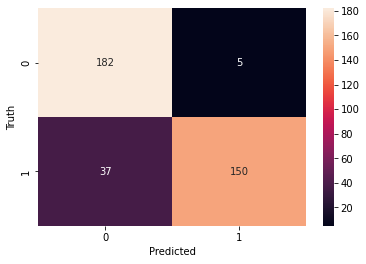

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)

from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       187
           1       0.97      0.80      0.88       187

    accuracy                           0.89       374
   macro avg       0.90      0.89      0.89       374
weighted avg       0.90      0.89      0.89       374

